## Training and Evaluation Process
### Training process:
Firstly model is trained for face recognition task using cross-entropy loss.
Backbone is a resnet variant while head is just FC layer.
I tried to play with ArcFace but it requires much more time to fine tune pipeline for it.

### Evaluation process:
After each training iteration we can use trained checkpoint for evaluation on LFW using distance metric over embeddings.
Used distance metrics:
- cosine
- l2

## Results
In the end after training model achieved less than 4% EER on LFW dataset using cosine distnace.

Plots with results can be viewed at ./results/*.png.
As can be observed, l2 is more prone to overfitting due to high dimensionality of embedding vectors. 

Metrics from iteration with best eer (iter 83):
- Cosine EER: 3.8%
- Cosine Accuracy at EER th: 96.2%

Overall, the results achieved for baseline are quite good, compared to the first CNN results from back in mid 2010s (Accuracy of DeepFace 98.37%)

## What can be improved:
### Pipeliene 
- Add checkpoint saving-loading, preserving all information required for continuing training
- Add checkpoint saving best on proxy metrics
- Add preprocessor arguments to config for initialization

### Ways to improve results:
Following steps can be done and listed in terms of how much accuracy can be improved considering same flops/mem constraints faster:
- Add scheduler (e.g. Cosine annealing with warm up)
- Smarter augmentations for train(e.g. Cutout, Mixup, face patching)
- Sampling (different algorithms to choose hard samples)
- Try different backbones / heads / optimizers
- Play with hyper parameters

In [1]:
from pathlib import Path
import yaml

import torch
from torch.utils.data import DataLoader
from addict import Dict
import albumentations as A
from albumentations.pytorch import ToTensorV2

from data.datasets import create_dataset, DATASETS_REGISTRY
from train import _init_model, evaluate

In [2]:
with open('./results/train_config.yml') as cfg_f:
        # load dict keys as class attributes
    config = Dict(yaml.safe_load(cfg_f))

In [3]:
device_name = config.device
device = torch.device(
    device_name if (
        torch.cuda.is_available() and 'cuda' in device_name
    ) else 'cpu'
)
print('Initialized device: {}\n'.format(device))

Initialized device: cuda:0



In [4]:
model = _init_model(config, device)
sd = torch.load('./results/checkpoint.pt')
model.load_state_dict(sd)

<All keys matched successfully>

In [5]:
PATH_TO_LFW_DATA = ''
# get class for lfw
val_dataset = DATASETS_REGISTRY[config.data.val_dataset]
# prepare data
_ = val_dataset.prepare_data(PATH_TO_LFW_DATA, './processed_data/test_lfw.json')

3000it [00:00, 35176.69it/s]
3000it [00:00, 35265.51it/s]


In [6]:
val_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    A.Resize(32, 32),
    ToTensorV2()
])

val_ds = create_dataset(
    config.data.val_dataset,
    './processed_data/test_lfw.json',
    val_transforms
)
    
pin_memory = True if 'cpu' not in '{}'.format(device) else False
val_iterator = DataLoader(
    val_ds, 
    batch_size=config.data.val_batch_size, 
    num_workers=config.num_workers, 
    drop_last=False, 
    pin_memory=pin_memory, 
    persistent_workers=False,
)

In [7]:
metrics = evaluate(val_iterator, model, device, val_loss=None)

100%|██████████| 47/47 [00:07<00:00,  6.00it/s]


### Metrics

In [8]:
content = 'Val cosine acc at 0.0 th: {:.3f}%\n'.format(metrics['cosine'][2] * 100)
content += 'Val cosine acc at eer_th: {:.3f}%\n'.format(metrics['cosine'][3] * 100)
content += 'Val cosine eer (th: {:.4f}): {:.3f}%\n'.format(metrics['cosine'][1], metrics['cosine'][0] * 100)
content += '\n'
content += 'Val l2 acc at eer_th: {:.3f}%\n'.format(metrics['l2'][2] * 100)
content += 'Val l2 eer (th: {:.4f}): {:.3f}%'.format(metrics['l2'][1], metrics['l2'][0] * 100)
print(content)

Val cosine acc at 0.0 th: 66.483%
Val cosine acc at eer_th: 96.200%
Val cosine eer (th: 0.2950): 3.800%

Val l2 acc at eer_th: 94.333%
Val l2 eer (th: -25.2449): 5.667%


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
def displayImage(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Cosine FRR/FAR

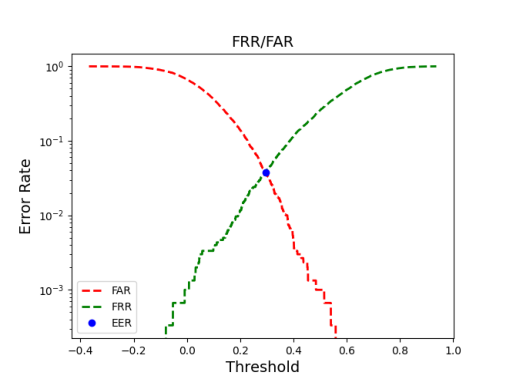

In [10]:
displayImage(metrics['cosine'][-1].numpy().transpose(1, 2, 0))

### L2 FRR/FAR

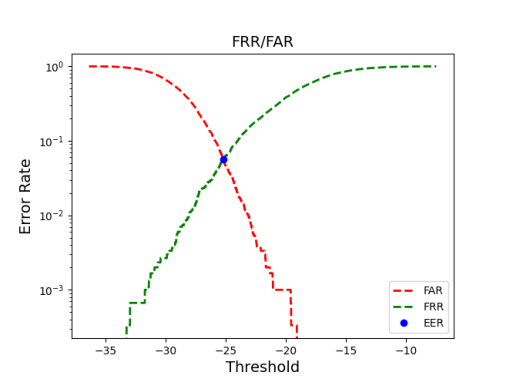

In [11]:
displayImage(metrics['l2'][-1].numpy().transpose(1, 2, 0))